In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, util, transform
from PIL import Image

# 1. Entrene una red de Hopfield ‘82 con un conjunto de imágenes binarias.

Recordatorios de tamaños

El vector de la imagen original aplanada → (N,).

El vector de la imagen con ruido (x0) → (N,).

La matriz de pesos W → (N, N).

Todas las imagenes tienen que tener el mismo tamaño

1. Preprocesar los patrones. Las imagenes son binarias, están en 0 (negro) y 1/255 (blanco).

    Las redes de Holpfield trabajan con +1/-1

    Tengo que aplicar una función signo que se aplique a cada imagen. 

2. Aplanar los patrones
    La red Hopfield funciona con vectores de tamaño N (uno por neurona).

    Si la imagen es de 28x28, el vector tendrá 784 entradas.
    Convierto una matriz de 3D o 2D a un vector de 1D

In [2]:
import numpy as np
from PIL import Image

def preparar_patterns(img_list: list, size=(45,60)) -> np.ndarray:
    img_aplanadas_vec = []
    for arr in img_list:
        # 1) gris (0..255)
        img = Image.fromarray(arr).convert("L")
        # 2) resize sin suavizado
        img = img.resize(size, resample=Image.NEAREST)
        arr = np.array(img, dtype=np.uint8)          # (H,W), 0..255

        # 3) UMBRAL MANUAL (ajustable). Negros→1, fondo→0
        threshold = 200
        bin01 = (arr < threshold).astype(np.uint8)

        # 4) 0/1 -> ±1 y aplanar
        signo = (bin01 * 2 - 1).astype(np.int8)
        vec = signo.reshape(-1)
        img_aplanadas_vec.append(vec)

    patterns = np.stack(img_aplanadas_vec)
    return patterns

In [3]:
def calcular_matriz_conn(patterns):
    P, N = patterns.shape
    W = np.zeros((N, N), dtype=np.float32)
    for p in patterns:
        W += np.outer(p, p)
    W /= P
    np.fill_diagonal(W, 0.0)
    return 0.5 * (W + W.T)

In [4]:
def agg_ruido_img(img_1d: np.ndarray, frac: float, rng=None) -> np.ndarray:
    rng = rng or np.random.default_rng()
    x = img_1d.reshape(-1)   # <- importante
    y = x.copy()
    k = int(round(frac * x.size))
    if k > 0:
        idx = rng.choice(x.size, k, replace=False)
        y[idx] *= -1
    return y


import numpy as np

def borrar_img(vec: np.ndarray, frac: float, shape: tuple, axis: str = "cols") -> np.ndarray:
    """
    Borra un porcentaje de la imagen (pone -1 en esa región).
    
    vec   : patrón 1D en {-1,+1}
    frac  : fracción a borrar (0..1)
    shape : (alto, ancho) de la imagen
    axis  : "cols" para columnas, "rows" para filas
    
    Devuelve: nuevo vector 1D con parte borrada
    """
    img = vec.reshape(shape).copy()

    H, W = shape
    if axis == "cols":
        n_cols = int(W * frac)
        img[:, -n_cols:] = -1
    elif axis == "rows":
        n_rows = int(H * frac)
        img[-n_rows:, :] = -1
    else:
        raise ValueError("axis debe ser 'cols' o 'rows'")

    return img.reshape(-1)


In [5]:
def mostrar_patron(vec, shape, titulo=""):
    """
    vec   : patrón 1D en {-1,+1}
    shape : (alto, ancho) de la imagen
    """
    img = vec.reshape(shape)
    # mapear {-1,1} a {255,0} → blanco/negro
    img = ((-img + 1) * 127.5).astype(np.uint8)

    plt.imshow(img, cmap="gray")
    plt.title(titulo)
    plt.axis("off")

In [6]:
def update_sync(s, W):
    s = s.reshape(-1).astype(np.int8)
    h = W @ s
    out = np.sign(h).astype(np.int8)
    out[out == 0] = s[out == 0]
    return out

def update_async(s, W):
    y = s.reshape(-1).copy().astype(np.int8)
    N = y.size
    for i in np.random.permutation(N):
        h_i = np.dot(W[i, :], y)
        if   h_i > 0: y[i] =  1
        elif h_i < 0: y[i] = -1
    return y


def Hopfield_train(x0: np.ndarray, W: np.ndarray, mode: str = "async"):
    s = x0.copy()
    sweeps = 0
    if mode == "async":
        while True:
            sweeps += 1
            s_new = update_async(s, W)
            if np.array_equal(s_new, s):
                return s_new, sweeps, True, False
            s = s_new
    elif mode == "sync":
        s_prev = None
        while True:
            sweeps += 1
            s_new = update_sync(s, W)
            if np.array_equal(s_new, s):
                return s_new, sweeps, True, False
            if s_prev is not None and np.array_equal(s_new, s_prev):
                return s_new, sweeps, True, True
            s_prev, s = s, s_new
    else:
        raise ValueError("mode debe ser 'async' o 'sync'")


#### Selecciono a las imagenes con el tamaño de (45, 60) y hago el primer entrenamiento de la red

# Punto a

In [ ]:
import os
images = []
images_shape = []
#files = ['dataset/paloma.bmp', 'dataset/panda.bmp', 'dataset/perro.bmp',
#         'dataset/quijote.bmp', 'dataset/torero.bmp', 'dataset/v.bmp']
files = ['dataset/paloma.bmp','dataset/quijote.bmp', 'dataset/torero.bmp']

for data in files:
    if '.bmp' in data:
        image = io.imread(data)
        images.append(image)
        images_shape.append(image.shape)
images_shape = list(set(images_shape))
print(images_shape)

In [ ]:
images_train = [] 
for image in images:
    if image.shape == images_shape[0]:
        images_train.append(image)

In [ ]:
images_train

In [ ]:
H, W = images_shape[0]
patterns = preparar_patterns(images_train, size=(W, H))  # PIL usa (W,H)

W_hopfield = calcular_matriz_conn(patterns)


In [ ]:
patterns

In [ ]:
x0 = patterns[0].copy()  # vector ±1
# correr Hopfield
s_final, sweeps, converged, two_cycle = Hopfield_train(x0, W_hopfield, mode="async")

In [ ]:
H, W = images_shape[0]   
x0_img = x0.reshape(H, W)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
mostrar_patron(x0_img, (H, W), "Patrón inicial")

plt.subplot(1,2,2)
mostrar_patron(s_final, (H, W), "Imagen recuperada")

plt.show()

# Punto b (Le agrego ruido a las imagenes)

In [8]:
import os
images = []
images_shape = []
files = ['dataset/panda.bmp', 'dataset/perro.bmp', 'dataset/v.bmp']

for data in files:
    if '.bmp' in data:
        image = io.imread(data)
        images.append(image)
        images_shape.append(image.shape)
images_shape = list(set(images_shape))
print(images_shape)

[(50, 50)]


In [9]:
images_train = [] 
for image in images:
    if image.shape == images_shape[0]:
        images_train.append(image)

In [ ]:
images_train

In [ ]:
H, W = images_shape[0]
patterns = preparar_patterns(images_train, size=(W, H))  # PIL usa (W,H)
W_hopfield = calcular_matriz_conn(patterns)
x0 = patterns[2].copy()  # vector ±1
x0_ruido = agg_ruido_img(x0, 0.2)
# correr Hopfield
s_final, sweeps, converged, two_cycle = Hopfield_train(x0_ruido, W_hopfield, mode="async")


In [ ]:
H, W = images_shape[0]   
x0_img = s_final.reshape(H, W)

plt.figure(figsize=(8,4))

plt.subplot(1,2,2)
mostrar_patron(x0_img, (H, W), "Patrón recuperado")

plt.subplot(1,2,1)
mostrar_patron(x0_ruido, (H, W), "Patrón con ruido")

plt.show() 

In [46]:
H, W = images_shape[0]
patterns = preparar_patterns(images_train, size=(W, H))  # PIL usa (W,H)
W_hopfield = calcular_matriz_conn(patterns)
x0 = patterns[0].copy()  # vector ±1
x0_borrado = borrar_img(x0, 0.9, (H, W), axis="cols")
# correr Hopfield
s_final, sweeps, converged, two_cycle = Hopfield_train(x0_borrado, W_hopfield, mode="async")

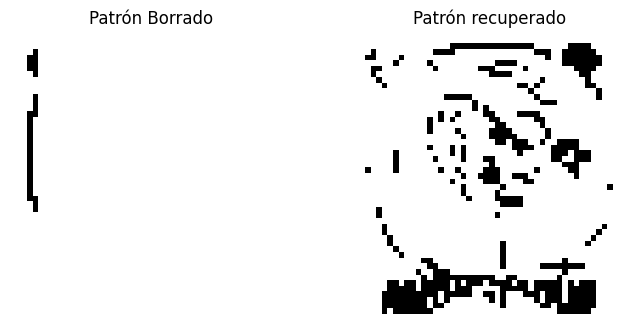

In [47]:
H, W = images_shape[0]   
x0_img = s_final.reshape(H, W)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
mostrar_patron(x0_borrado, (H, W), "Patrón Borrado")

plt.subplot(1,2,2)
mostrar_patron(x0_img, (H, W), "Patrón recuperado")

plt.show() 


